In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = ''

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASH = getHash(name,[architecture,props])
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_0_0_e_e_1_0_1_con_data_nor_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_nat_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2857607, 828)
(2857607, 8)
validation
(411229, 828)
(411229, 8)
test
(355293, 828)
(355293, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 828)]             0         
                                                                 
 dense (Dense)               (None, 2048)              1697792   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 8)                 1032    

In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000
29/29 [==============================] - 37s 873ms/step - loss: 2.0762 - STD: 0.0383 - MAE: 0.2167 - val_loss: 2.0553 - val_STD: 0.0295 - val_MAE: 0.2170
Epoch 2/10000
29/29 [==============================] - 17s 585ms/step - loss: 2.0491 - STD: 0.0316 - MAE: 0.2167 - val_loss: 2.0353 - val_STD: 0.0310 - val_MAE: 0.2162
Epoch 3/10000
29/29 [==============================] - 17s 587ms/step - loss: 1.9215 - STD: 0.0571 - MAE: 0.2099 - val_loss: 1.9285 - val_STD: 0.0862 - val_MAE: 0.2069
Epoch 4/10000
29/29 [==============================] - 18s 598ms/step - loss: 1.7801 - STD: 0.0928 - MAE: 0.2007 - val_loss: 1.8839 - val_STD: 0.1082 - val_MAE: 0.2019
Epoch 5/10000
29/29 [==============================] - 18s 608ms/step - loss: 1.7143 - STD: 0.1025 - MAE: 0.1967 - val_loss: 1.7819 - val_STD: 0.1151 - val_MAE: 0.1968
Epoch 6/10000
29/29 [==============================] - 17s 581ms/step - loss: 1.5584 - STD: 0.1172 - MAE: 0.1875 - val_loss: 1.6390 - val_STD: 0.1362 - val_MAE:

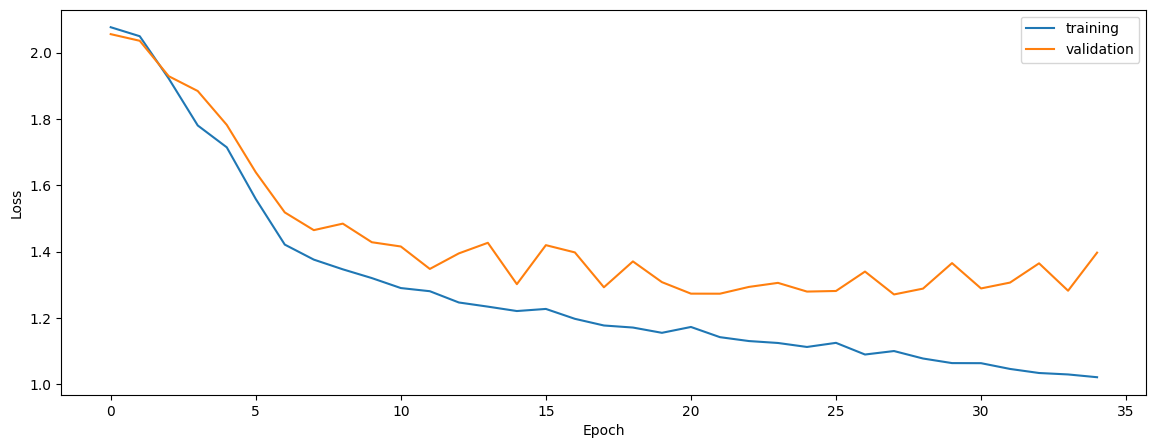

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced
0.5803495722119941
0.5057303838007533
0.4709662166155821


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original
0.5513706554614277
0.5192192900870386
0.45413148012845567


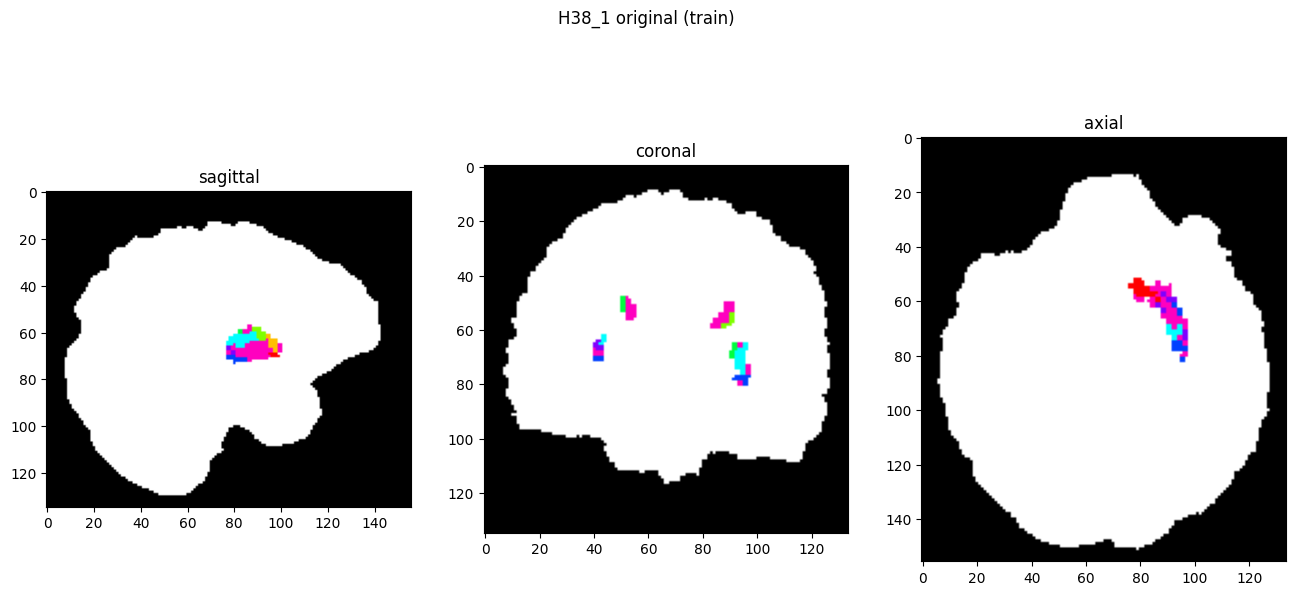

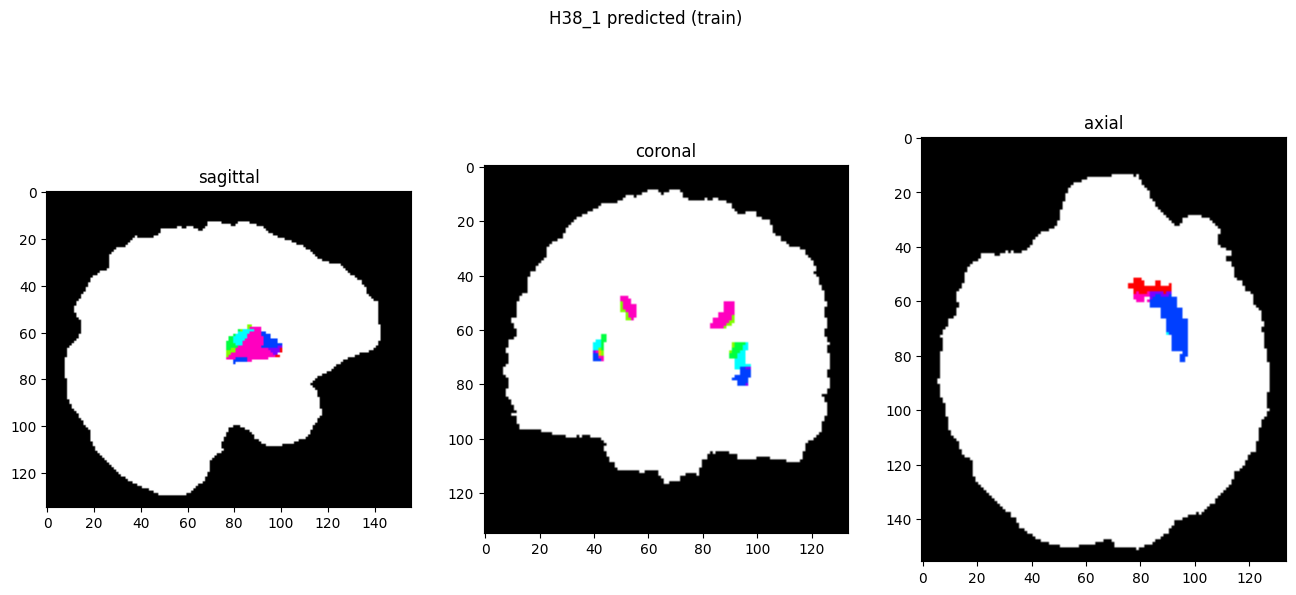

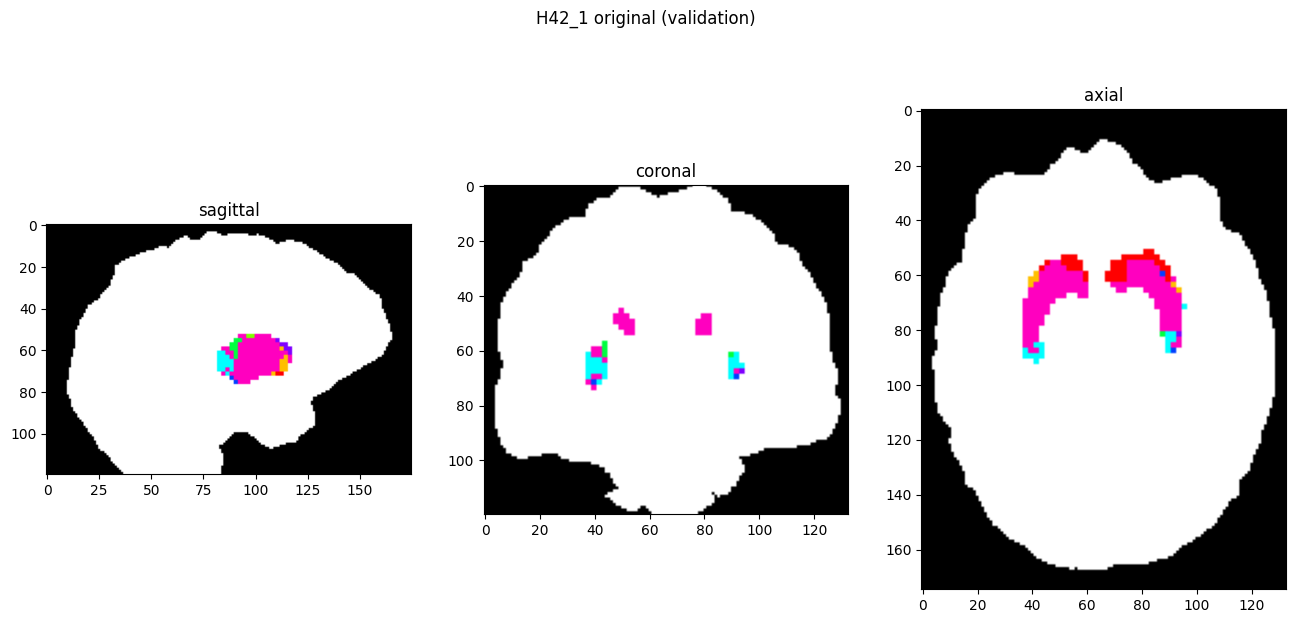

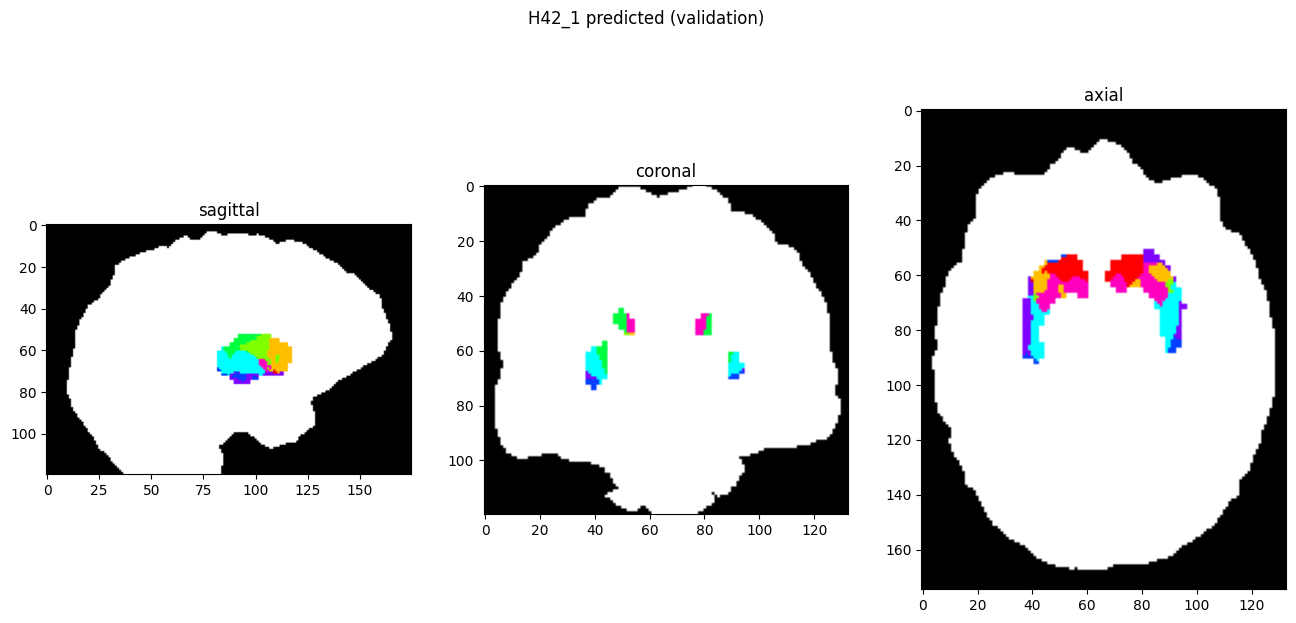

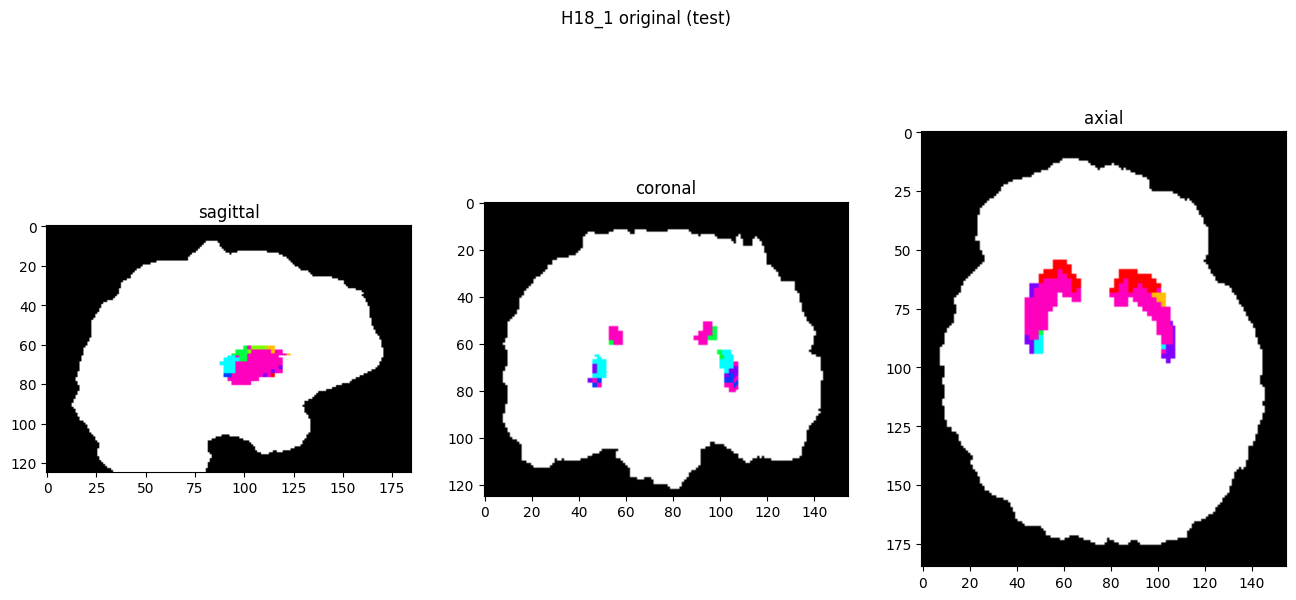

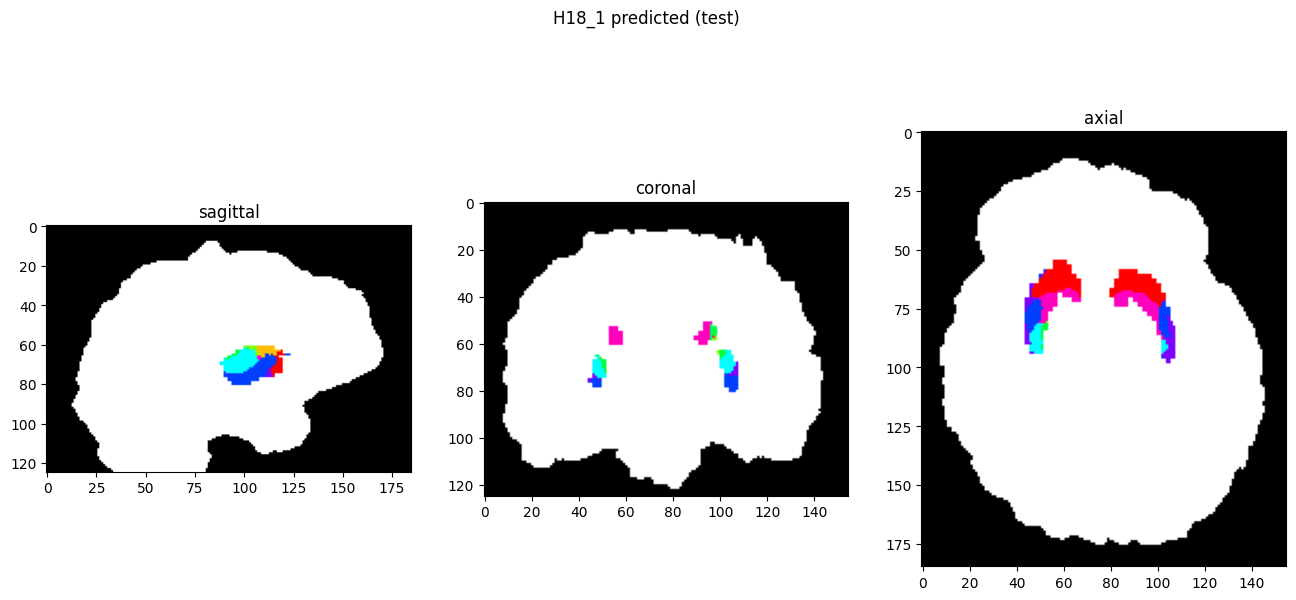

In [9]:
showResults(model, gen, threshold=0)